<a href="https://colab.research.google.com/github/mrunalmania/Foodvision/blob/main/Foodvision_Big.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. Pytorch Model deploymrnt

What is model deployment?

Machine learning model deployment is the act of making your machine learning model(s) avaialable to someone or somthing else.



## 0. Get Setup

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.2.2+cu121
torchvision version: 0.17.2+cu121


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 33.97 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [ ]:
# we need to set the device agnostic code :
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting data

The dataset we are going to use for deploying food vision mini model is...

Pizza, steak, sushi 20% dataset (pizza, steak, suchi classes from Food101 dataset with random 20%)

In [ ]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
# setup training and test paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. Foodvision mini model deployment experiment outline

### 3. questions
1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go
3. How is my model going to function?

**Foodvision mini Ideal use case:** A model that performs well and fast

  * performs well: 95+ % accuracy
  * Fast: as close to real-time or faster (30 FPS plus)

To try and achieve this goals, we are going to build two model experiments:
1. EffNetB2 feature extractor
2. ViT feature extractor





## 3. Creating an EffNetB2 extractor

Feature extractor = a term for transfer learning model, that has its base layers frozen and output layers or head layers customize to certain probelm

EffNetB2 pre-trained model in pytorch model available

In [ ]:
import torchvision

torchvision.__version__

'0.17.2+cu121'

In [ ]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # default is equivalent to best avaiable

# 2  Get the EffnetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup the pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# 4. Freeze the base layers in model (this will stop all layers from training in model)
for param in effnetb2.parameters():
  param.requires_grad = False


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 80.1MB/s]


In [ ]:
from torchinfo import summary


# print effnetb2 model summary
summary(
    effnetb2,
    input_size = (1,3,224,224),
    col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
    col_width = 20,
    row_settings = ['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [ ]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [ ]:
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias = True)
)

In [ ]:

# print effnetb2 model summary
summary(
    effnetb2,
    input_size = (1,3,224,224),
    col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
    col_width = 20,
    row_settings = ['var_names']
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.1 creating a function to make an EffnetB2 feature extractor

In [ ]:
def create_effnetb2_model(num_classes: int = 3,
                          seed: int = 42,
                          ):
  # 1, 2, 3 above
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change the classifier head with randomseed
  torch.manual_seed(seed=seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3),
      nn.Linear(in_features=1408, out_features=num_classes)
  )
  return model, transforms

In [ ]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3, seed=42)



In [ ]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# print effnetb2 model summary
summary(
    effnetb2,
    input_size = (1,3,224,224),
    col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
    col_width = 20,
    row_settings = ['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.2 Creating Dataloaders for EffnetB2

In [ ]:
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=effnetb2_transforms, batch_size=32)


In [ ]:
class_names

['pizza', 'steak', 'sushi']

In [ ]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2)

(15, 5)

### 3.3 Training effnet_b2 feature extractor

loss function, optimizer, Training_function(engine.py)

In [ ]:
from going_modular.going_modular import engine

# loss function
loss_fn = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)

# Training function
set_seeds()

effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.9721 | train_acc: 0.5646 | test_loss: 0.7355 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7212 | train_acc: 0.8458 | test_loss: 0.5855 | test_acc: 0.9381
Epoch: 3 | train_loss: 0.5809 | train_acc: 0.8583 | test_loss: 0.4873 | test_acc: 0.9625
Epoch: 4 | train_loss: 0.4474 | train_acc: 0.9021 | test_loss: 0.4301 | test_acc: 0.9347
Epoch: 5 | train_loss: 0.4347 | train_acc: 0.8938 | test_loss: 0.3884 | test_acc: 0.9352
Epoch: 6 | train_loss: 0.4180 | train_acc: 0.8875 | test_loss: 0.3501 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4243 | train_acc: 0.8708 | test_loss: 0.3241 | test_acc: 0.9534
Epoch: 8 | train_loss: 0.3842 | train_acc: 0.8958 | test_loss: 0.3380 | test_acc: 0.9506
Epoch: 9 | train_loss: 0.3724 | train_acc: 0.8958 | test_loss: 0.3086 | test_acc: 0.9131
Epoch: 10 | train_loss: 0.3547 | train_acc: 0.8604 | test_loss: 0.2801 | test_acc: 0.9625


In [ ]:
!nvidia-smi


Tue Apr  9 01:23:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0              35W /  70W |   1167MiB / 15360MiB |     68%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### 3.4 Inspecting EffnetB2 loss curves

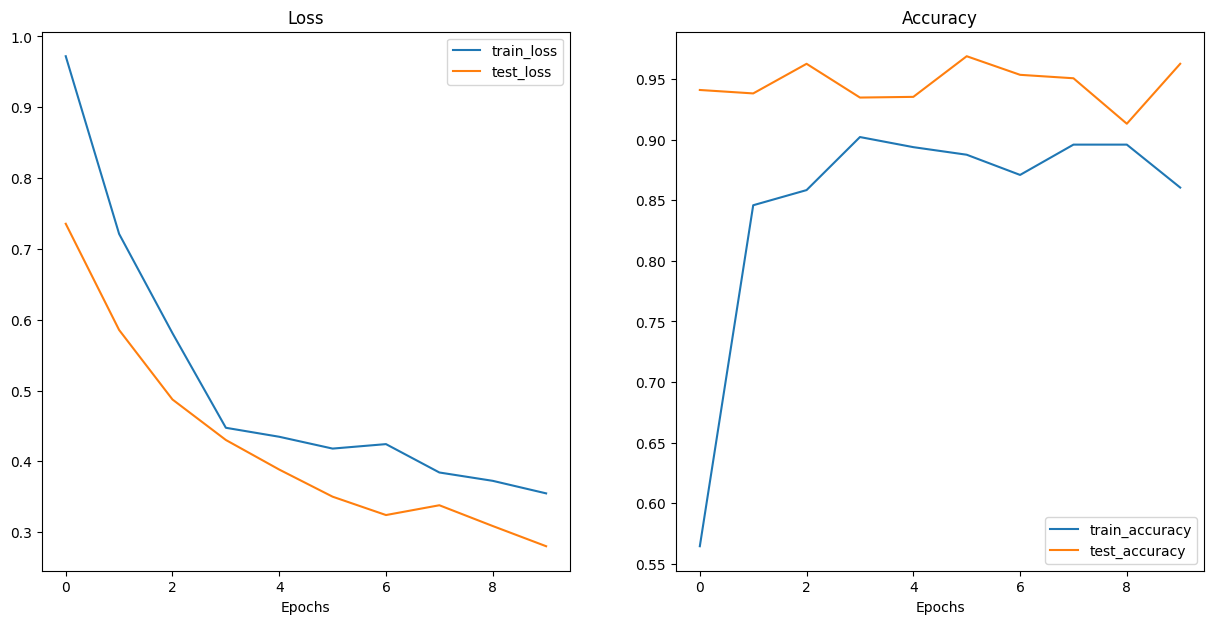

In [ ]:
from helper_functions import  plot_loss_curves

plot_loss_curves(effnetb2_results)

### 3.5 Saving the effnetb2 feature extractor

In [ ]:
from going_modular.going_modular import utils

# save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_sushi_20_percent.pth


### 3.6 Inspecting the size of the effnet-b2 feature extractor

Why would it be important to consider the size of the saved model?

If we're deploying our model to be used on a mobile app/website, there may be limited compute resources.

So if our model file is too large, we may not be able to store/run it on our target device.



In [ ]:
from pathlib import Path

# get the model size in bytes and then convert it to the MB (mega-byte)

pretrained_effnetb2_model_size = Path("/content/models/09_pretrained_effnetb2_feature_extractor_pizza_sushi_20_percent.pth").stat().st_size / (1024*1024)

print(f"Pretrained effnetb2 model size = {round(pretrained_effnetb2_model_size,2)} MB")

Pretrained effnetb2 model size = 29.86 MB


### 3.7 Collecting EffnetB2 feature extractor stats

In [ ]:
# Count the number of parameters in effnetb2

effenet_b2_total_param = sum(torch.numel(param)
 for param in effnetb2.parameters())

effenet_b2_total_param

7705221

In [ ]:
# create a dictionary with effnetb2 stats

effnet_stats = {"test_loss": effnetb2_results['test_loss'][-1],
                "test_acc": effnetb2_results['test_acc'][-1],
                "number_of_parameters": effenet_b2_total_param,
                "model_size (MB)": pretrained_effnetb2_model_size}

effnet_stats

{'test_loss': 0.28009578585624695,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8607120513916}

## 4. Creating a ViT feature extractor


In [ ]:
# Check out the heads layer
Vit = torchvision.models.vit_b_16()
Vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
def create_vit_model(num_classes:int = 3,
                     seed:int = 42):
  # Create Vit_B_16 pretraind weights, transforms, model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # Freeze all the base layers
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier head to suit our needs
  torch.manual_seed(seed)

  model.heads = nn.Sequential(
      nn.Linear(in_features=768, out_features=num_classes)
  )

  return model, transforms


In [ ]:
vit, vit_transforms = create_vit_model()
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 108MB/s] 


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# print effnetb2 model summary
summary(
    vit,
    input_size = (1,3,224,224),
    col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
    col_width = 20,
    row_settings = ['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1 Creates dataloaders for Vit Feature extractor

In [ ]:
from going_modular.going_modular import data_setup

train_dataloader_vit, test_dataloder_vit ,class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                         test_dir = test_dir,
                                                                         transform = vit_transforms,
                                                                         batch_size = 32)

len(train_dataloader_vit) , len(test_dataloder_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Training ViT feature extractor

We are up to experiment Vit feature extractor

In [ ]:
from going_modular.going_modular import engine

# Setup the optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)

# loss function
loss_fn = torch.nn.CrossEntropyLoss()

# train vit feature extractor with seed
set_seeds()

vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloder_vit,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           epochs=10,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


### 4.3 Polt the loss curves

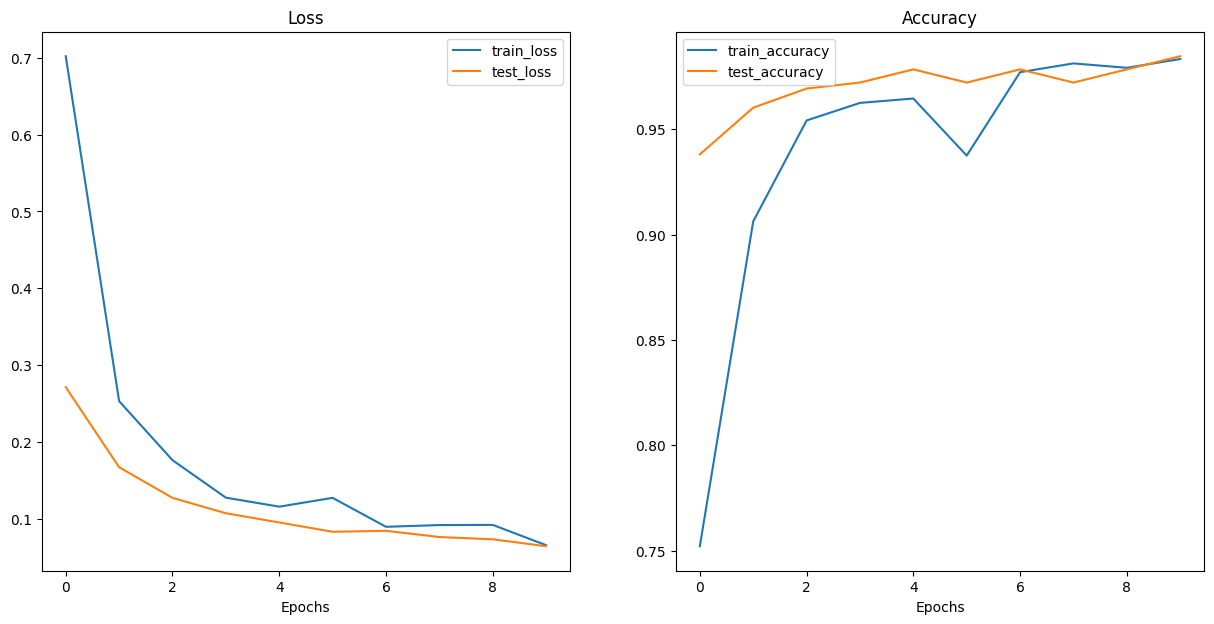

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

For more  ideal loss curves should look like : see custom dataset section

### 4.4 Saving vit feature extractor

In [ ]:
# save model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor.pth


### 4.5 checking the size of vit feature extractor

In [ ]:
from pathlib import Path

# Check the size of the model
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor.pth").stat().st_size / 1024**2
print(f"Model size: {pretrained_vit_model_size:.2f} MB")

Model size: 327.37 MB


In [ ]:
pretrained_effnetb2_model_size

29.8607120513916

### 4.6 ollecting vit feature extractor stats

In [ ]:
# Count number of parameters in vit

vit_total_param = sum(p.numel() for p in vit.parameters())
print(f"Total parameters: {vit_total_param:,}")

Total parameters: 85,800,963


In [ ]:
effenet_b2_total_param

7705221

In [ ]:
# Create a Vit Stats dictionary
vit_stats = {
    "test_loss": vit_results["test_loss"][-1],
    "test_acc": vit_results["test_acc"][-1],
    "number_of_parameters": vit_total_param,
    "model_size (MB)": pretrained_vit_model_size
}

vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3664722442627}

## 5. Making predictions with our trained model and timing

Our goal:
1. Performs well (95%+ accuracy)
2. Speed: 30FPS + (real-time)

To test criteria 2:
1. Loop through test images
2. Time how long each model taked to make a prediction on the image.

let's work towards making a function called "pred_and_store()" to do so.

First we need a list of test image path

In [ ]:
from pathlib import Path

# get all test data path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/796922.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3497151.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3174637.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/441659.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3375083.jpg')]

### 5.1 Creating a function to make prediction across the test datasets.


1. Create a function that takes a list of paths and a trained model and  a series of transforms, and list of target task name and target device

2. Creating an empty list (can return a full list of all predictions later).

3. Loop through the target input path.

4. Create an empty dict for each sample

5. Get the sample path and ground truth class from the filepath.

6. Start the prediction timer.

7. Open the image using `PIL.Image.open()`.

8. Transform the image to be usable with a given model.

9. Prepare the model for inference by sending it to the target device. and turning on `eval()` mode.

10. Turn on the `torch.inference_mode()` and pass the target transformed image to the model and perform the forwrd pass, calculate pred prob and calculate pred class.

11. Add the pred prob + pred class to the empty diction from step 4.

12. Stop the pred timer, and add the time to the prediction dictionary.

13. See if the predicted class matches the ground truth class.

14. Append the updated pred dict to the empty list of pred created in 2.

15. return the list of pred dicts.


In [ ]:
import pathlib
import torch
import PIL
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    pred_list = []

    for path in tqdm(paths):
        pred_dict = {}

        pred_dict["image_path"] = path
        class_name =  path.parent.stem
        pred_dict["class_name"] = class_name

        start_time = timer()

        img = Image.open(path)

        transformed_image = transform(img).unsqueeze(0).to(device)

        model = model.to(device)
        model.eval()

        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]  # class_names is a python variable that is on cpu and pred_label is torch tensor on GPU , need to move it to the cpu.

            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time - start_time, 4)

        pred_dict["correct"] = pred_dict["class_name"] == pred_dict["pred_class"]
        pred_list.append(pred_dict)

        pred_list.append(pred_dict)

    return pred_list




### 5.2 making a timimng prediction with effnetb2

1. Device - we're going to hardcode our predictions to happen on CPU (beacuse we are always getting GPU)
2. Transforms - we want to make sure each of the models are predicting on images that have been prepared with appropriate transforms (e.g EffnetB2 with effnetb2_transforms)

In [ ]:
# Make prediction across test dataset

effnetb2_test_pred_list = pred_and_store(test_data_paths,
                                         effnetb2,
                                         effnetb2_transforms,
                                         class_names,
                                         "cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
effnetb2_test_pred_list[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/796922.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.7166,
  'pred_class': 'pizza',
  'time_for_pred': 0.2008,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/796922.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.7166,
  'pred_class': 'pizza',
  'time_for_pred': 0.2008,
  'correct': True}]

In [ ]:
# Turn the test_pred_dicts into dataframes

import pandas as pd

effnetb2_test_df = pd.DataFrame(effnetb2_test_pred_list)
effnetb2_test_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/7...,pizza,0.7166,pizza,0.2008,True
1,data/pizza_steak_sushi_20_percent/test/pizza/7...,pizza,0.7166,pizza,0.2008,True
2,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9880,pizza,0.1321,True
3,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9880,pizza,0.1321,True
4,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9200,pizza,0.1208,True


In [ ]:
# check the number of correct predictions
effnetb2_test_df["correct"].value_counts()

correct
True     288
False     12
Name: count, dtype: int64

In [ ]:
# Find the avg time per pred
effenet_b2_avg_time_per_pred = effnetb2_test_df["time_for_pred"].mean()
effenet_b2_avg_time_per_pred

0.12431266666666668

In [ ]:
# Add time_per_pred to effnet_b2_stats
effnet_stats["time_per_pred_cpu"] = effenet_b2_avg_time_per_pred
effnet_stats

{'test_loss': 0.28009578585624695,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8607120513916,
 'time_per_pred_cpu': 0.12431266666666668}

**Note** prediction time will vary (much like a training time) depending on the hardware you are using.

### 5.3 Making and timing predictions with ViT

In [ ]:
# Make list of prediction dictionary with ViT feature extractor model on test images

vit_test_pred_list = pred_and_store(test_data_paths,
                                   vit,
                                   vit_transforms,
                                   class_names,
                                   "cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# check the first feq Vit prediction
vit_test_pred_list[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/796922.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9732,
  'pred_class': 'pizza',
  'time_for_pred': 1.1673,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/796922.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9732,
  'pred_class': 'pizza',
  'time_for_pred': 1.1673,
  'correct': True}]

In [ ]:
# turn vit_test_pred_list into dataframe
import pandas as pd

vit_test_df = pd.DataFrame(vit_test_pred_list)
vit_test_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/7...,pizza,0.9732,pizza,1.1673,True
1,data/pizza_steak_sushi_20_percent/test/pizza/7...,pizza,0.9732,pizza,1.1673,True
2,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9938,pizza,1.2721,True
3,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9938,pizza,1.2721,True
4,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9989,pizza,0.8444,True


In [ ]:
# see how many correct
vit_test_df["correct"].value_counts()

correct
True     296
False      4
Name: count, dtype: int64

In [ ]:
# avg pred time
vit_avg_time_per_pred = vit_test_df["time_for_pred"].mean()
vit_avg_time_per_pred

0.7444353333333333

In [ ]:
# Add the avg time per pred to vit_stat
vit_stats["time_per_pred_cpu"] = vit_avg_time_per_pred
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3664722442627,
 'time_per_pred_cpu': 0.7444353333333333}

In [ ]:
effnet_stats

{'test_loss': 0.28009578585624695,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8607120513916,
 'time_per_pred_cpu': 0.12431266666666668}

## 6. Comparing model results, prediction times and size

In [ ]:
# Turn state dictionaries into dataframe

df = pd.DataFrame([effnet_stats, vit_stats])

# Add column for model names
df["model"] = ["effnetb2", "vit"]

# Convert the test_acc to the percentage
df["test_acc"] = round(df["test_acc"] * 100, 2)

# convert te acc to perces
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.280096,96.25,7705221,29.860712,0.124313,effnetb2
1,0.064435,98.47,85800963,327.366472,0.744435,vit


In [ ]:
# Compare the Vit to effentb2 across different characteristics.

pd.DataFrame(data=(df.set_index("model").loc["vit"] / df.set_index("model").loc["effnetb2"]),columns=["ViT to Effnet ratio"])


,ViT to Effnet ratio
test_loss,0.230045
test_acc,1.023065
number_of_parameters,11.135432
model_size (MB),10.963117
time_per_pred_cpu,5.988411


### 6.1 Visualizing the speed vs performance tradeoff.

So we've compared our effnetb2 and vit feature extractor models, now let's visualize the comparizon with speed vs. performance plot.



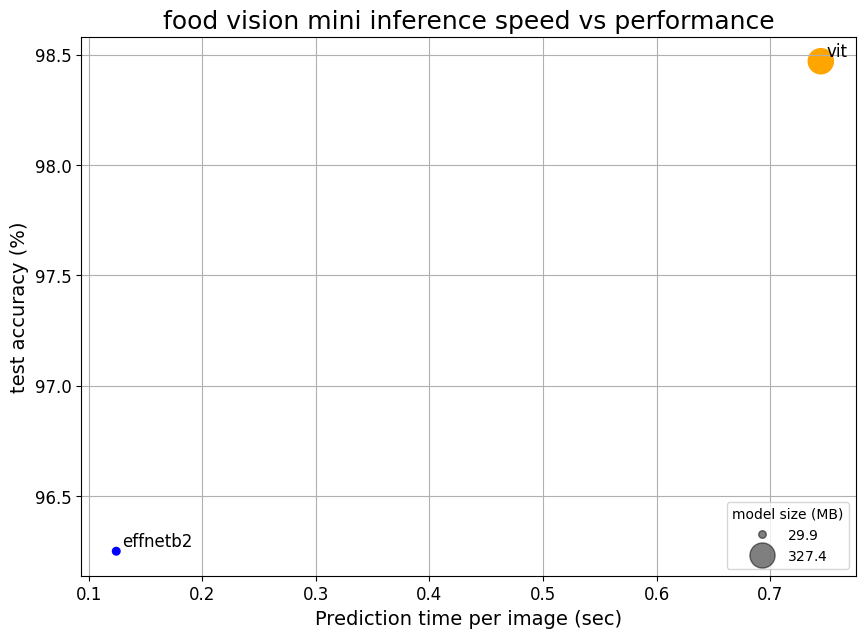

In [ ]:
import matplotlib.pyplot as plt
# 1. Create a plot from model comparison dataframes

fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)")

# 2. add titles and labels
ax.set_title(label="food vision mini inference speed vs performance",
       fontsize=18)
ax.set_xlabel(xlabel="Prediction time per image (sec)",
       fontsize=14)
ax.set_ylabel(ylabel="test accuracy (%)",
       fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

# 3. Annotate the samples on the scatter plot so we know what's are going on.
for index, row in df.iterrows():
  ax.annotate(text=row["model"],
              xy=(row["time_per_pred_cpu"]+0.005, row["test_acc"]+0.02),
              size=12)

# 4. leend
handles, labels = scatter.legend_elements(prop="sizes",
                                         alpha=0.5)
model_sze_legend = ax.legend(handles=handles,
                        labels=labels,
                        loc="lower right",
                        title="model size (MB)")

# Save the figure
plt.savefig(fname="food_vision_mini_inference.png",
            dpi=300)

## 7. Bringing foodvision mini to life by creating a Gradio demo

We've chosen

In [ ]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 81.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.8 MB/s eta 0:00:00
Gradio version: 4.26.0


In [ ]:
gr.__version__

'4.26.0'

### 7.1 Gradio overview

Gradio helps you create machine learning demmo.

So other people can use your model to classify images.

THe overall premise of Gradio is map Inputs -> function/Model -> outputs.

### 7.2  Create a function to map our inputs and outputs.


In [ ]:
# Put our model on cpu
effnetb2 = effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

Let's create a function called `predict()` to go form:

```
images of food -> ML model (EffnetB2) -> outputs (food class label)

```

In [ ]:
from typing import Tuple, Dict
from timeit import default_timer as timer
def predict(img) -> Tuple[Dict, float]:
  # here float is we need prediction time as output also.

  # start a timer
  start_time = timer()

  # transform the input image

  img = effnetb2_transforms(img).unsqueeze(0) # adding a batch dimension
  # put model into eval mode
  effnetb2.eval()

  with torch.inference_mode():
    # forward pass
    logits = effnetb2(img)

    pred_prob = torch.softmax(logits, dim=1)

  pred_lables_and_probs = {class_names[i]: float(pred_prob[0][i]) for i in range(len(class_names))}
  # make prediction

  end_time = timer()
  pred_time = round(end_time - start_time,4)

  return pred_lables_and_probs, pred_time

In [ ]:
import random

from PIL import Image

# get a list of all test image file path
test_data_path = list(Path(test_dir).glob("*/*.jpg"))

# get a random image path
random_image = random.choice(test_data_path)

# open the image
img = Image.open(random_image)

result = predict(img)
result

({'pizza': 0.08362261950969696,
  'steak': 0.602360188961029,
  'sushi': 0.314017117023468},
 0.1166)

### 7.3 Creating a list of example images

The examples for the gradio can be created with the `example` parameter

In [ ]:
# Create a list of example input to our gradio demo.

example_list = [[str(filepath)] for filepath in random.sample(test_data_path, k=3)]

example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/420409.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/3494950.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/86782.jpg']]

### 7.4 Build a gradio interface.

Let's build `gr.interface()` to go form

input -> function/Model -> output: pred, prob, prob time


In [ ]:
import gradio as gr

# Create a gradio interface

# Create title, desc, article
title = "Food Vision"
description = "An effientnetb2 model to classify food images. (Pizza, Steak, Sushi)"
article = "Created at pytorch_model_deployment"


# Create a gradio demo
demo = gr.Interface(fn=predict,
                 inputs=gr.Image(type="pil"),
                outputs = [gr.Label(num_top_classes=3, label="Predictions"), gr.Number(label="Prediction time (s)")],
                    examples = example_list,
                    title = title,
                    description = description,
                    article = article
                )

# Launch the demo
demo.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://a04f708286feceb219.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://a04f708286feceb219.gradio.live


### Now we need to use Huggingface spaces

## 8. Turning our Foodvision mini Gradio demp to deployable app

our gradio demo is going to expire after 72 Hours

And to do this, we need to prepare our app files so we can host them on huggingface spaces

### 8.1 What is hugging face spaces
A simple way to host the ML demo applications

### 8.2 Deployed app structure

Let's start to put all of our app files into a single directory:

```
Colab -> folder with all gradio files -> upload app files to huggingface spaces -> deploy

```

### 8.3 Creating a demos folder to store our FoodVision app files

In [ ]:
# shutil -> high level python file level operation
import shutil
from pathlib import Path

# create a folder named demos
food_vision_mini_demo_path = Path("demos/foodvision_mini")

# remove the folder if it exists and create a new directory
if food_vision_mini_demo_path.exists():
    shutil.rmtree(food_vision_mini_demo)
    food_vision_mini_demo_path.mkdir(parents=True,
                                     exist_ok=True)
else:
    food_vision_mini_demo_path.mkdir(parents=True,
                                     exist_ok=True)

!ls demos/foodvision_mini

### 8.4 Creating a folder of example images to use with our FoodVision Mini demo

What we want:
  * 3 images in an `example/` directory
  * Images should be from the test set

In [ ]:
import shutil
from pathlib import Path
import random

# creates an example directory:
foodvision_mini_example_path = Path("demos/foodvision_mini/examples")


foodvision_mini_example_path.mkdir(parents=True,
                                       exist_ok = True)


# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the images to the examples folder
for example in foodvision_mini_examples:
    destination = foodvision_mini_example_path / example.name
    print(f"[Info] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[Info] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[Info] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[Info] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


Let's now verify that we can get a list of list from our ``examples`` folder, since gradio expects a list of lists.

In [ ]:
import os

# Get example file path list of list
example_list = [['examples/' + example] for example in os.listdir(foodvision_mini_example_path)]

example_list

[['examples/2582289.jpg'], ['examples/592799.jpg'], ['examples/3622237.jpg']]

### 8.5 Moving our trained EffnetB2 model to our Food vision mini demo directory

In [ ]:
import shutil

# Create a source path for our model

effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_sushi_20_percent.pth"

# Create a destination path
effnetb2_foodvision_mini_model_destination = food_vision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the model file
try:
  print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

  # Move the model
  shutil.move(src=effnetb2_foodvision_mini_model_path, dst=effnetb2_foodvision_mini_model_destination)
  print(f"[INFO] Model move complete")

except:
  print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, parhaps its already been moved?")
  print(f"[INFO] Model exist at {effnetb2_foodvision_mini_model_destination}: {os.path.exists(effnetb2_foodvision_mini_model_destination)}")



[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_sushi_20_percent.pth
[INFO] Model move complete


### 8.6 Turning off EffNetB2 model into a python script (model.py)

We have saved `.pth` model `state_dict` and want to load it into a model isinstance
let's move oue `create_effnetb2_model()` function to a script so we can reuse it.

In [ ]:
%%writefile demos/foodvision_mini/model.py

import torch
import torchvision
from torch import nn
from torchvision import transforms
import torch.nn.functional as F



def create_effnetb2_model(num_classes: int = 3,
                          seed: int = 42,
                          ):
  # 1, 2, 3 above
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change the classifier head with randomseed
  torch.manual_seed(seed=seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3),
      nn.Linear(in_features=1408, out_features=num_classes)
  )
  return model, transforms

Writing demos/foodvision_mini/model.py


### 8.7 Turning our Foodvision Mini Gradio app into a python script

The `app.py` file has 4 major part

1. Imports and class names setup
2. Model and transform preparation
3. Predict function (`predict`)
4. Gradio app - Gradio inteface plus launch command


In [ ]:
%%writefile demos/foodvision_mini/app.py

import torch
import torchvision
from torch import nn
import gradio as gr
from model import create_effnetb2_model
import os
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup the class name
class_names = ["pizza", "steak", "sushi"]

# 2. Model and transform preparation
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=len(class_names), seed=42)

# Load the save weights
effnetb2.load_state_dict(torch.load(f"09_pretrained_effnetb2_feature_extractor_pizza_sushi_20_percent.pth",
                                    map_location=torch.device("cpu") # load the model to CPU (because in HF we have default cpu)

                                    ))

# 3. Predict function
def predict(img) -> Tuple[Dict, float]:
  # here float is we need prediction time as output also.

  # start a timer
  start_time = timer()

  # transform the input image

  img = effnetb2_transforms(img).unsqueeze(0) # adding a batch dimension
  # put model into eval mode
  effnetb2.eval()

  with torch.inference_mode():
    # forward pass
    logits = effnetb2(img)

    pred_prob = torch.softmax(logits, dim=1)

  pred_lables_and_probs = {class_names[i]: float(pred_prob[0][i]) for i in range(len(class_names))}
  # make prediction

  end_time = timer()
  pred_time = round(end_time - start_time,4)

  return pred_lables_and_probs, pred_time

# Gradio app.
# Create title, desc, article
title = "Food Vision"
description = "An effientnetb2 model to classify food images. (Pizza, Steak, Sushi)"
article = "Created at pytorch_model_deployment"

# create the example list (list of list)
example_list = [['examples/' + example] for example in os.listdir("examples")]

# Create a gradio demo
demo = gr.Interface(fn=predict,
                 inputs=gr.Image(type="pil"),
                outputs = [gr.Label(num_top_classes=3, label="Predictions"), gr.Number(label="Prediction time (s)")],
                    examples = example_list,
                    title = title,
                    description = description,
                    article = article
                )

# Launch the demo
demo.launch(debug=True)


Writing demos/foodvision_mini/app.py


### 8.8 Creating `requirements.txt`

the requirements file will tell our hugging face space what software dependencies our app requires.

* torch
* torchvision
* gradio

In [ ]:
%%writefile demos/foodvision_mini/requirements.txt

torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_mini/requirements.txt


## 9. Deploying our FoodVision mini app huggingface spaces

In [ ]:
!ls demos/foodvision_mini/examples

2582289.jpg  3622237.jpg  592799.jpg


In [ ]:
# Change into foodvision_min directory and then zip inside
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__" "*.ipynb_checkpoints*"

  adding: 09_pretrained_effnetb2_feature_extractor_pizza_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 55%)
  adding: examples/ (stored 0%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: model.py (deflated 50%)
  adding: requirements.txt (deflated 6%)


In [ ]:
# Download
try:
  from google.colab import files
  files.download("foodvision_mini.zip")
except:
  print(f"Not running in Google colab, can't use google.colab.files.download please download manually ")

Not running in Google colab, can't use google.colab.files.download please download manually 


## 10. Creating a food vision big.

FoodVision Mini works well with 3 classes (pizza, steak, sushi).

So all of experimenting is paying off...

Let's step things up a nothc and make FoodVision BIG!! using all of the Food101 classes.


### 10.1 Creating a model for Food Vision Big +Transforms.

In [ ]:
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes = 101)


In [ ]:
from torchinfo import summary

# Print EffnetB2 model summary
summary(effnetb2_food101, input_size=(1, 3, 224,224),
                                      col_names = ["input_size", "output_size", "num_params", "trainable"],
                                      col_width = 20,
                                      row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

We need to add some data augmentation to our tranforms to avoid the overfitting.

Since we're working with larger dataset, we mat want to introduce some data augmentation techniques.

* This is because with larger datasets and larger models, overfitting becomes more of a problem.

* Because we're working with a large number of classes, let's use TrivialAugment as our data augmentation layer.


In [ ]:
# Create training data transforms.
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms
])

food_101_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [ ]:
# Testing data transforms -> without data augment.
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 10.2 Getting data for foodvision big.

Get the food101 dataset.


In [ ]:
from torchvision import datasets

from pathlib import Path

data_dir = Path("data")

# Get the training data (~750 * 101 (750 images foe 101 class each) )

# And testing data (~250 * 101) (250 images for 101 class each)

train_data = datasets.Food101(data_dir, split = "train", transform = food101_train_transforms, download =True)
test_data = datasets.Food101(data_dir, split="test", transform=effnetb2_transforms, download=True)


100%|██████████| 4996278331/4996278331 [04:15<00:00, 19538003.08it/s]


Extracting data/food-101.tar.gz to data


In [ ]:
# Get food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### 10.3 Creating a subset of the Food101 datasets for faster experimenting

Why create a subset?

We want to our first few experiments to run as quick as possible.


To do so, lets make 20% of the data from the Food101 dataset.


In [ ]:
from torch.utils.data import random_split


def split_dataset(dataset: torchvision.datasets,
                  split_size: float = 0.2,
                  seed:int = 42):
  # Create split len based on the original dataset len
  length_1 = int(len(dataset) * split_size)
  length_2 = len(dataset) - length_1

  # Print out info
  print(f"[INFO] SPlitting dataset of length {len(dataset)} into splits of size {length_1} and {length_2}")

  # Create split with given random seed
  random_split_1, random_split_2 = random_split(dataset, [length_1, length_2], generator = torch.manual_seed(seed))
  return random_split_1, random_split_2


  # Create train and test split


In [ ]:
# create training 20 percent split food101
train_data_food101_20_percent, _ = split_dataset(train_data, 0.2)


# create testing 20 percent split food101
test_data_food101_20_percent, _ = split_dataset(test_data, 0.2)

[INFO] SPlitting dataset of length 75750 into splits of size 15150 and 60600
[INFO] SPlitting dataset of length 25250 into splits of size 5050 and 20200


In [ ]:
len(train_data_food101_20_percent), len(test_data_food101_20_percent)

(15150, 5050)

### 10.4 Turning our Food101 datasets to dataloader

In [ ]:
import torch
import os

NUM_WORKERS = os.cpu_count()

BATCH_SIZE = 32

# Create training dataloader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS
                                                                  )

# Create testing dataloader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers = NUM_WORKERS)

In [ ]:
len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(474, 158)

### 10.5 Training FoodVision Big

Thnigs for training

* 5 epochs for trainig:
* optimier: torch.optim.Adam(lr=1e-3)
* loss function: torch.nn.CrossEntropyLoss(label_smoothing=0.1)


Why use label smoothing?
Label smoothing helps to prevent overfitting (it's a regularization technique)

Without label smoothinh in 5 classes:

```
[0.0, 0.0, 0.99, 0.01, 0.0]

```

With label smoothing in 5 classes:

```
[0.01, 0.01, 0.96, 0.01, 0.01]

```

Smoothed out the overconfidence.


In [ ]:
from going_modular.going_modular import engine

# Setup the optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Setup the loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Want to beat the original food101 paper (56.4 percent accuracy in test data)
set_seeds(42)

effnet_food101_results = engine.train(model=effnetb2_food101,
                                      train_dataloader = train_dataloader_food101_20_percent,
                                      test_dataloader = test_dataloader_food101_20_percent,
                                      optimizer=optimizer,
                                      loss_fn = loss_fn,
                                      epochs=5,
                                      device = device)


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 3.6391 | train_acc: 0.2757 | test_loss: 2.7795 | test_acc: 0.4907
Epoch: 2 | train_loss: 2.8566 | train_acc: 0.4420 | test_loss: 2.4723 | test_acc: 0.5345
Epoch: 3 | train_loss: 2.6528 | train_acc: 0.4836 | test_loss: 2.3623 | test_acc: 0.5592
Epoch: 4 | train_loss: 2.5425 | train_acc: 0.5138 | test_loss: 2.3020 | test_acc: 0.5713
Epoch: 5 | train_loss: 2.4951 | train_acc: 0.5259 | test_loss: 2.2765 | test_acc: 0.5847


### 10.6 Inspecting loss curves of FoodVision Big model

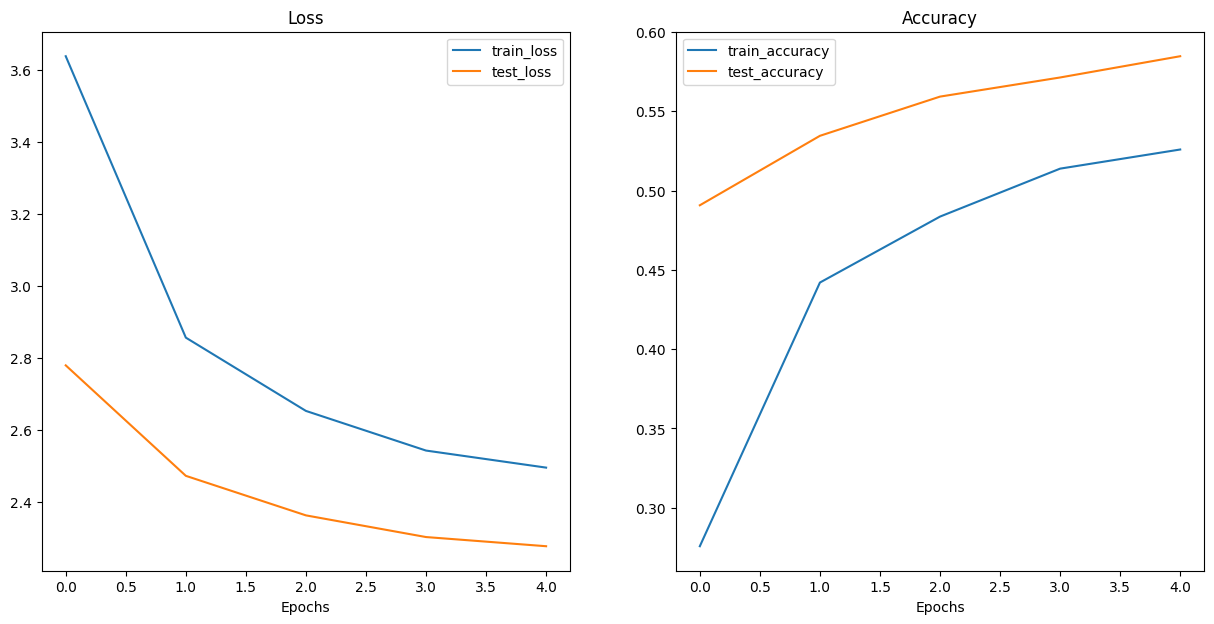

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnet_food101_results)

### 10.7 Save and load FoodVision Big model

In [ ]:
from going_modular.going_modular import utils

# create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_extractor_food101_20_percent.pth"

# Save the model
utils.save_model(model=effnetb2_food101,
                 target_dir="models/",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_extractor_food101_20_percent.pth


In [ ]:
# Create a food101 compatible EffnetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load in the saved state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_extractor_food101_20_percent.pth"))



<All keys matched successfully>

### 10.8 Cheching Foodvision Big model size

In [ ]:
from pathlib import Path

# get the model size in bytes then convert in megabytes (MB)

pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024)

print(f"Model size: {pretrained_effnetb2_food101_model_size} MB")

Model size: 30 MB


## 11. Turning our FoodVision Big model to deployable app.

Why deploy a model?
Deployinh a model allows you to see how your model goes in the real-world.

In [ ]:
from pathlib import Path

# Create foodvision big demo path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make foodvision big demo deirectory
foodvision_big_demo_path.mkdir(parents=True,
                               exist_ok=True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path / "examples").mkdir(parents=True,
                                          exist_ok=True)

In [ ]:
!ls demos/foodvision_big/

examples


### 11.1 Downloading an example image and moving it to example directory.

In [ ]:
# Download and move example image
! wget https://img.freepik.com/free-psd/freshly-baked-pizza-with-cut-slice-isolated-transparent-background_191095-9041.jpg?w=740&t=st=1712632699~exp=1712633299~hmac=16382489ca23e0338dcf4963f99fa1813b19f7f39e691671277a32b4c2e60be7


--2024-04-09 03:19:48--  https://img.freepik.com/free-psd/freshly-baked-pizza-with-cut-slice-isolated-transparent-background_191095-9041.jpg?w=740
Resolving img.freepik.com (img.freepik.com)... 104.98.118.147, 2600:1409:8800::1737:a851, 2600:1409:8800::1737:a83a
Connecting to img.freepik.com (img.freepik.com)|104.98.118.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 158861 (155K) [image/jpeg]
Saving to: ‘freshly-baked-pizza-with-cut-slice-isolated-transparent-background_191095-9041.jpg?w=740’

freshly-baked-pizza 100%[===================>] 155.14K   292KB/s    in 0.5s    

2024-04-09 03:19:49 (292 KB/s) - ‘freshly-baked-pizza-with-cut-slice-isolated-transparent-background_191095-9041.jpg?w=740’ saved [158861/158861]

mv: cannot stat '09_example_image.jpg': No such file or directory


In [ ]:
!mv pizza_img.jpg demos/foodvision_big/examples

In [ ]:
!mv models//09_pretrained_effnetb2_extractor_food101_20_percent.pth demos/foodvision_big/

In [ ]:
food101_class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

### 11.2 Saving Food101 class names to file (`class_names.txt`)

Let's save all of the food101 class names to a file.

In [ ]:
# Create a path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"



In [ ]:
# Write food101 class names to text file.
with open(foodvision_big_class_names_path, "w") as f:
  print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
  f.write("\n".join(food101_class_names)) # new line per class name

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


In [ ]:
# open food101 class name file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
  food101_class_names_loaded = f.readlines()
  food101_class_names_loaded = [class_name.strip() for class_name in food101_class_names_loaded]

food101_class_names_loaded

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

### 11.3 Turning our foodvision big model into python script

In [ ]:
%%writefile demos/foodvision_big/model.py

import torch
import torchvision
from torch import nn
from torchvision import transforms
import torch.nn.functional as F



def create_effnetb2_model(num_classes: int = 3,
                          seed: int = 42,
                          ):
  # 1, 2, 3 above
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change the classifier head with randomseed
  torch.manual_seed(seed=seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3),
      nn.Linear(in_features=1408, out_features=num_classes)
  )
  return model, transforms

Writing demos/foodvision_big/model.py


### 11.4 Turning our FoodVision Big gradio app into a python script (`app.py`)

for class names we need to import from `class_names.txt` rather than a python list.

We'll need to make sure our model is suitable for FoodVision Big.

In [ ]:
%%writefile demos/foodvision_big/app.py
###  1. Imports and class names setup ###
import gradio as gr
import torch
from PIL import Image
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import os
from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup the classnames
with open("class_names.txt", "r") as f:
  class_names = [food.strip() for food in f.readlines()]

# Create model and transforms
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=len(class_names))

# load the save weights
effnetb2.load_state_dict(torch.load(f="09_pretrained_effnetb2_extractor_food101_20_percent.pth",
                                    map_location=torch.device("cpu")))

### predicti function

def predict(img) -> Tuple[Dict, float]:
  # here float is we need prediction time as output also.

  # start a timer
  start_time = timer()

  # transform the input image

  img = effnetb2_transforms(img).unsqueeze(0) # adding a batch dimension
  # put model into eval mode
  effnetb2.eval()

  with torch.inference_mode():
    # forward pass
    logits = effnetb2(img)

    pred_prob = torch.softmax(logits, dim=1)

  pred_lables_and_probs = {class_names[i]: float(pred_prob[0][i]) for i in range(len(class_names))}
  # make prediction

  end_time = timer()
  pred_time = round(end_time - start_time,4)

  return pred_lables_and_probs, pred_time


### Gradio app.
# Create title, desc, article
title = "Food Vision Big"
description = "An effientnetb2 model to classify food images of classes 101"
article = "Created at pytorch_model_deployment"

# create the example list (list of list)
example_list = [['examples/' + example] for example in os.listdir("examples")]

# Create a gradio demo
demo = gr.Interface(fn=predict,
                 inputs=gr.Image(type="pil"),
                outputs = [gr.Label(num_top_classes=5, label="Predictions"), gr.Number(label="Prediction time (s)")],
                    examples = example_list,
                    title = title,
                    description = description,
                    article = article
                )

# Launch the demo
demo.launch(debug=True)


Overwriting demos/foodvision_big/app.py


In [ ]:
torchvision.__version__

'0.17.2+cu121'

### 11.5 Creating a requirements.txt

In [ ]:
%%writefile demos/foodvision_big/requirements.txt
gradio==4.26.0
torch==2.2.2
torchvision==0.17.2
httpx==0.27.0

Writing demos/foodvision_big/requirements.txt


### 11.6 Downloading foodvision big app files

In [ ]:
# Change into foodvision_min directory and then zip inside
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__" "*.ipynb_checkpoints*"

updating: 09_pretrained_effnetb2_extractor_food101_20_percent.pth (deflated 8%)
updating: app.py (deflated 55%)
updating: class_names.txt (deflated 48%)
updating: examples/ (stored 0%)
updating: examples/pizza_img.jpg (deflated 1%)
updating: model.py (deflated 50%)
updating: requirements.txt (deflated 13%)
